## Image classification 

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [34]:
directory = "/Users/laurameyer/code/DSP-Tan/mushroom_learning/raw_data/Mushrooms"

In [85]:
def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir

In [86]:
data_dir = get_images_directory(directory)
data_dir

PosixPath('/Users/laurameyer/code/DSP-Tan/mushroom_learning/raw_data/Mushrooms')

In [87]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6714


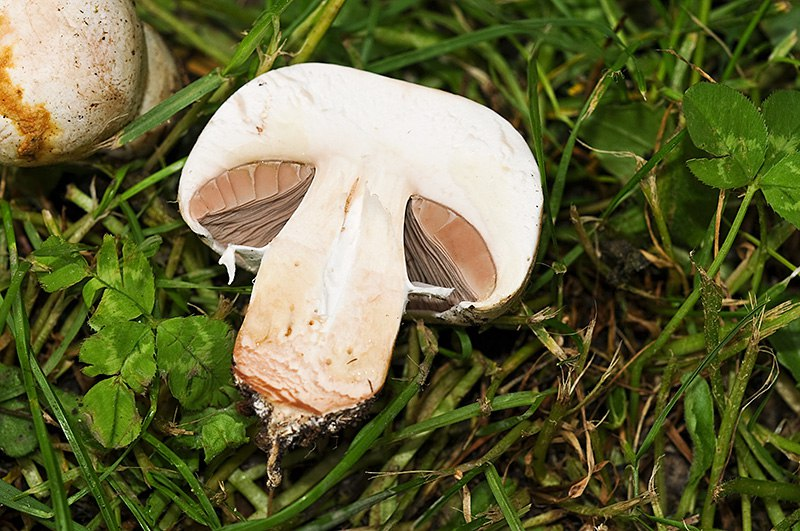

In [88]:
mushrooms = list(data_dir.glob('Agaricus/*'))
PIL.Image.open(str(mushrooms[0]))

In [38]:
img_height = 224
img_width = 224
batch_size = 32

In [89]:
def load_training_data():

    return tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
    )

train_ds = load_training_data()

Found 6714 files belonging to 9 classes.
Using 5372 files for training.


In [40]:
def load_validation_data():
    return val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
    )

val_ds = load_validation_data()

Found 6714 files belonging to 9 classes.
Using 1342 files for validation.


In [33]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [90]:
class_names = train_ds.class_names
class_names

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

In [91]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


## Check which jpeg image is corrupted and delete it

In [96]:
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

In [49]:
normalization_layer = layers.Rescaling(1./255)

In [51]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [54]:
type(normalized_ds)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow import keras

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [93]:
from keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [94]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

127/168 [=====================>........] - ETA: 34s - loss: 2.0705 - accuracy: 0.2296

2022-02-28 19:13:46.288936: E tensorflow/core/lib/jpeg/jpeg_mem.cc:324] Premature end of JPEG data. Stopped at line 494/533


128/168 [=====================>........] - ETA: 34s - loss: 2.0686 - accuracy: 0.2310

InvalidArgumentError: Graph execution error:

jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_4323]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()